# Play SSS, record it, compute transfer functions

In [1]:
import sys
sys.path.insert(1, 'C:/Users/Matthieu/Documents/python/array_processing/toolboxes/')

from signal_processing import *
from NovakMethod import *

folder_str = 'C:/Users/Matthieu/Documents/experiments/antenne256_05_23/ManipViolon_Anech_230606/Calib4/'
manip_str = 'prise1'

import IPython.display as ipd

import scipy.io.wavfile

%matplotlib widget

## Use the SSS class to generate a SSS and play it.

Don't forget to set Megamicros before playing the SSS

Please set your python's editor volume in the mixer to a low level for the soundcard to not clip.

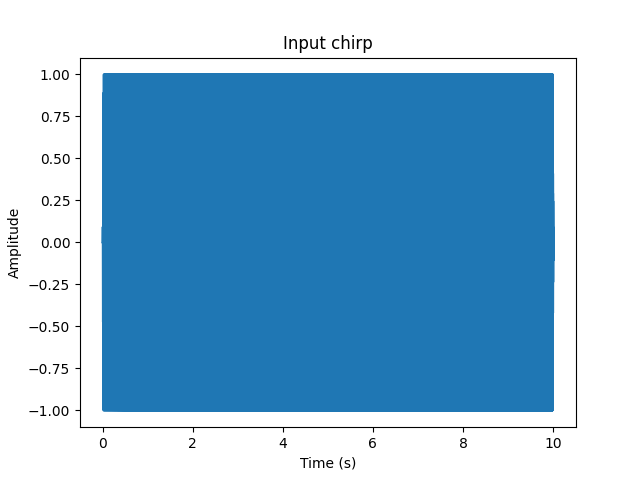

In [2]:
fs = 50000
t_approx = 10

fmin = 80
fmax = 20e3

TF_computation = SSSMethod(f1 = fmin, f2 = fmax, fs = fs, \
                           t_approx = t_approx, t_fading = 2e-3*t_approx, t_IR = 2, \
                            analytical_inverse_filter = True)
TF_computation.generate_synchronized_chirp(plot = True)



ipd.Audio(TF_computation.x, rate=fs, autoplay=True, normalize=True) # play a NumPy array as an audio

In [3]:
amp = np.iinfo(np.int16).max
data = amp*TF_computation.x

scipy.io.wavfile.write('Novakchirp_80Hz_20kHz_fs50kHz_10s.wav', rate = fs, data= data.astype(np.int16))


In [4]:
help(np.fft.fftfreq)


Help on function fftfreq in module numpy.fft:

fftfreq(n, d=1.0)
    Return the Discrete Fourier Transform sample frequencies.
    
    The returned float array `f` contains the frequency bin centers in cycles
    per unit of the sample spacing (with zero at the start).  For instance, if
    the sample spacing is in seconds, then the frequency unit is cycles/second.
    
    Given a window length `n` and a sample spacing `d`::
    
      f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even
      f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd
    
    Parameters
    ----------
    n : int
        Window length.
    d : scalar, optional
        Sample spacing (inverse of the sampling rate). Defaults to 1.
    
    Returns
    -------
    f : ndarray
        Array of length `n` containing the sample frequencies.
    
    Examples
    --------
    >>> signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)
    >>> fourier = np.fft.fft(signal)
    >>> n = 

## Imports the recordings of the Megamicros system

In [5]:
subfolder = 'Mu_recordings/'
Nmems = 8
Nref = 1
Ntime, Mems, Ref = ReadDat(folder_str + subfolder + manip_str + '.dat', Fe = fs, Narray = Nmems, Nanalog = Nref, ind_ref = -1)
time_vec = np.arange(Ntime)/fs

# ind_Mems = [6,7]#np.random.randint(0,Nmems,3)

# plt.figure()
# plt.subplot(2,1,1)
# plt.plot(time_vec,Mems[ind_Mems,:].transpose(), alpha = 0.5)
# plt.title('The signal from some random Mems')
# plt.ylabel('Amplitude')
# plt.legend(np.arange(8), loc = 'best')
# plt.subplot(2,1,2)
# plt.plot(time_vec,Ref.transpose(), alpha = 0.5)
# plt.title('The signal from the reference channels')
# plt.ylabel('Amplitude')
# plt.xlabel('Time (s)')
# plt.legend(['Genelec'])
# plt.tight_layout()
# plt.show()

## Spectrogram of the reference signal

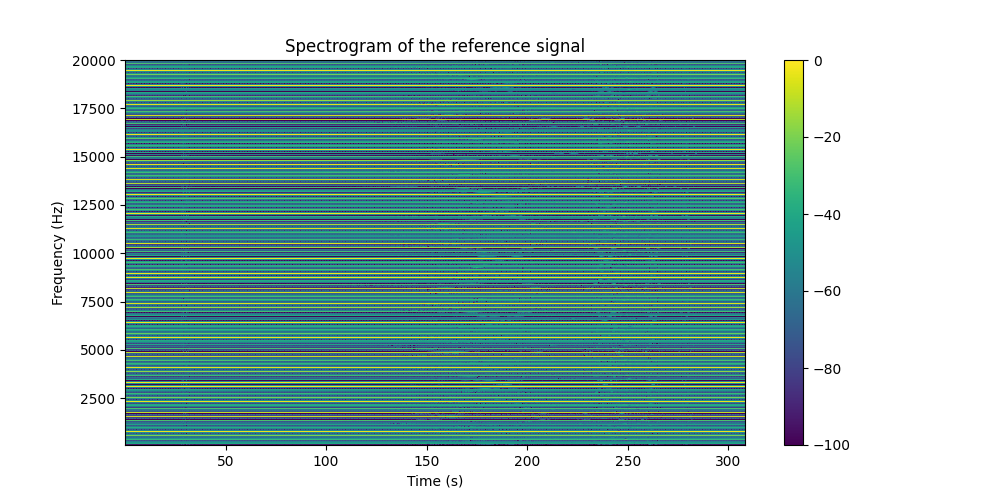

In [6]:
Nfft = 2**12

f_spectro, t_spectro, spectro_source = scipy.signal.spectrogram(Ref, fs = fs, nperseg = Nfft)


f_spectro, t_spectro, spectro_ref = scipy.signal.spectrogram(Ref, fs = fs, nperseg = Nfft)

DR = 100
spectro_ref = spectro_ref.squeeze()
spectro_ref_dB = 20*np.log10(spectro_ref/spectro_ref.max())
spectro_ref_dB[spectro_ref_dB< -DR] = -DR 
f_spectro.shape
t_spectro.shape
spectro_ref.shape
plt.figure(figsize = (10, 5))
plt.pcolormesh(t_spectro, f_spectro, spectro_ref_dB) #, shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram of the reference signal')
plt.ylim([80,20e3])
plt.show()

## Computes Transfer functions with Novak method for each Megamicros channel 

### Compute transfer functions

In [7]:
Sigs = np.vstack((Mems,Ref))
TF_computation.set_measurements(Sigs)
TF_computation.compute_FR()

### Plot them

In [8]:
Mems_TF = TF_computation.X_tilde
freqvect = TF_computation.f_vect#np.arange(Nfreq)*(fs/Nfreq)


# plt.figure()
# plt.semilogx(freqvect,20*np.log10(np.abs(Mems_TF.transpose())))


C:\Users\Matthieu\AppData\Local\Temp\ipykernel_29624\1036835309.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(freqvect,20*np.log10(np.abs(Mems_TF[:,:].transpose())), alpha = 0.6)
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_29624\1036835309.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(freqvect,20*np.log10(np.abs(Ref_TF).transpose()))


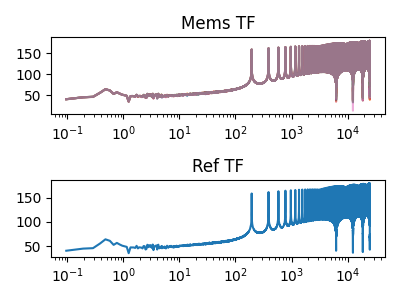

In [12]:
freqvect = TF_computation.f_vect
Mems_TF = TF_computation.H[:Nmems,:]
Ref_TF = TF_computation.H[-Nref:,:]

Nfreq = Mems_TF.shape[1]
# freqvect = np.arange(Nfreq)*(fs/(Nfreq))
plt.figure(figsize = (4,3))
plt.subplot(2,1,1)
# plt.semilogx(TF_computation.f_vect,20*np.log10(np.abs(Mems_TF[ind_Mems,:].transpose())))
plt.semilogx(freqvect,20*np.log10(np.abs(Mems_TF[:,:].transpose())), alpha = 0.6)
# plt.legend(np.arange(8), loc = 'best')

plt.title('Mems TF')
plt.subplot(2,1,2)
# plt.semilogx(TF_computation.f_vect,20*np.log10(np.abs(Ref_TF).transpose()))
plt.semilogx(freqvect,20*np.log10(np.abs(Ref_TF).transpose()))

plt.title('Ref TF')
plt.tight_layout()
plt.show()

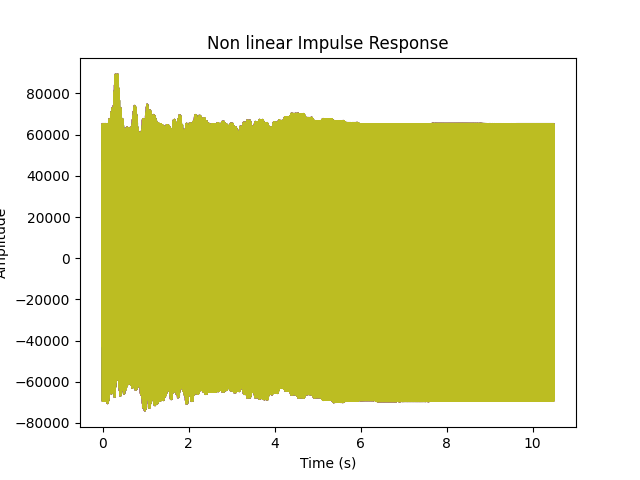

In [10]:
TF_computation.compute_IR(plot = True)

## TF between Mems and Ref



In [11]:
TF_Mems_vs_Ref = Mems_TF/Ref_TF

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_29624\1273909131.py:1: RuntimeWarning: invalid value encountered in true_divide
  TF_Mems_vs_Ref = Mems_TF/Ref_TF
